In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS

Assume we have an observer in Tai Mountain.

In [3]:
taishan = EarthLocation(lat=36.2*u.deg, lon=117.1*u.deg, height=1500*u.m)

The observing period is the whole year of -2000 B.C.E. ~ 0 B.C.
To represent the epoch before the common era, I use the Julian date.

In [23]:
# Check the relationship between the unit year and day
x =1 * u.year
x.to(u.day)

<Quantity 365.25 d>

In [31]:
year_arr = np.arange(2001, 4001, 1) * u.year
vernal_equinox = Time("2000-03-21 00:00:00") - year_arr
autumnal_equinox = Time("2000-09-23 00:00:00") - year_arr
vernal_equinox, autumnal_equinox

(<Time object: scale='utc' format='iso' value=['-1-03-06 18:00:32.000' '-2-03-06 12:00:32.000' '-3-03-06 06:00:32.000'
  ... '-1998-02-19 12:00:32.000' '-1999-02-19 06:00:32.000'
  '-2000-02-20 00:00:32.000']>,
 <Time object: scale='utc' format='iso' value=['-1-09-08 18:00:32.000' '-2-09-08 12:00:32.000' '-3-09-08 06:00:32.000'
  ... '-1998-08-24 12:00:32.000' '-1999-08-24 06:00:32.000'
  '-2000-08-24 00:00:32.000']>)

I counted the number of days of the vernal and autumnal equinox from the January 1.
They are 80 and 266 days, respectively.

In [44]:
day_num1 = Time("2000-03-21 00:00:00") - Time("2000-01-01 00:00:00")
day_num2 = Time("2000-09-23 00:00:00") - Time("2000-01-01 00:00:00")
print(day_num1, day_num2)

80.0 266.0


I calculate the altitude and azimuth of Sun and Canopus among 4:00~8:00 in autumnal equinox and 16:00~20:00 in vernal equinox for every year.

In [45]:
# Beginning of every year
year_arr = np.arange(2001, 4001, 1) * u.year
obs_time = Time("2000-01-01 00:00:00") - year_arr

# Calculate the observable time of everyday
beg_time1 = np.zeros_like(obs_time)
end_time1 = np.zeros_like(obs_time)
beg_time2 = np.zeros_like(obs_time)
end_time2 = np.zeros_like(obs_time)

for i, obs_timei in enumerate(obs_time):
    utcoffset = +8 * u.hour  # Daylight Time
    midnight = obs_timei - utcoffset

    # Position of the Canopus with the proper motion correction at the beginning of the year.
    # This effect is very small.
    dt_epoch = obs_timei.jyear - 2000.0
    ra = 95.98787790 * u.deg + 19.93 * u.mas * dt_epoch
    dec = -52.69571787 * u.deg + 23.24 * u.mas * dt_epoch
    hip30438 = SkyCoord(ra=ra, dec=dec, frame="icrs")
    
    # In the morning
    delta_midnight1 = np.arange(4, 8, 1./60) * u.hour
    obser_time1 = midnight + delta_midnight1 + day_num1
    local_frame1 = AltAz(obstime=obser_time1,
                        location=taishan)
    hip30438altazs1 = hip30438.transform_to(local_frame1)
    
    # position of Sun
    from astropy.coordinates import get_sun
    sunaltazs1 = get_sun(obser_time1).transform_to(local_frame1)
    
    mask = (sunaltazs1.alt < -0*u.deg) & (hip30438altazs1.alt > 0)
    observable_time1 = delta_midnight1[mask]
    # observable_time
    if len(observable_time1):
        beg_time1[i] = observable_time1.min().to('hr').value
        end_time1[i] = observable_time1.max().to('hr').value
        
    # In the afternoon
    delta_midnight2 = np.arange(16, 20, 1./60) * u.hour
    obser_time2 = midnight + delta_midnight2 + day_num2
    local_frame2 = AltAz(obstime=obser_time2,
                        location=taishan)
    
    hip30438altazs2 = hip30438.transform_to(local_frame2)
    
    # position of Sun
    from astropy.coordinates import get_sun
    sunaltazs2 = get_sun(obser_time2).transform_to(local_frame2)
    
    mask = (sunaltazs2.alt < -0*u.deg) & (hip30438altazs2.alt > 0)
    observable_time2 = delta_midnight2[mask]
    # observable_time
    if len(observable_time2):
        beg_time2[i] = observable_time2.min().to('hr').value
        end_time2[i] = observable_time2.max().to('hr').value    

I assume that the Canopus can be observed by the local observer only when the observable duration in one day is longer than 10 minitues.
With such an assumption, I determine the observable period of the Canopus.

In [73]:
# Observable duration
obs_dur1 = end_time1 - beg_time1
obs_dur2 = end_time2 - beg_time2

# For Autumnal equinox
# mask1 = (obs_dur1 >= 1./6)
mask1 = (obs_dur1 >= 0)
observable_date1 = obs_time[mask1]

# For vernal equinox
# mask2 = (obs_dur2 >= 1./6)
mask2 = (obs_dur1 >= 0)
observable_date2 = obs_time[mask2]

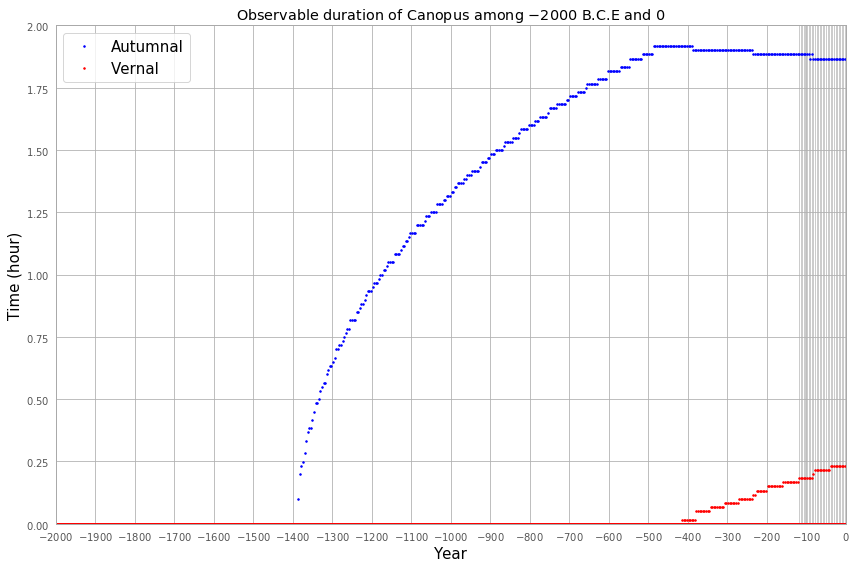

In [86]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(obs_time[mask1].jyear, obs_dur1[mask1],
          "b.", ms=3, label="Autumnal")
ax.plot(obs_time[mask2].jyear, obs_dur2[mask2],
          "r.", ms=3, label="Vernal")

ax.fill_between(obs_time.jyear, 0, 24,
                 (obs_dur1 >= 1./6) & (obs_dur2 >= 1./6), color="0.8", zorder=0)

ax.set_xlabel("Year", fontsize=15)
ax.set_xlim([-2000, 0])
ax.set_xticks(np.arange(-2000, 1, 100))

ax.set_ylim([0, 2.0])
ax.set_ylabel("Time (hour)", fontsize=15)
ax.set_title("Observable duration of Canopus among $-2000$ B.C.E and 0")

ax.legend(fontsize=15)

fig.tight_layout()
plt.savefig("-2000_0.eps", dpi=100)
plt.savefig("-2000_0.png", dpi=100)